# 複数のアクションを推薦する意思決定モデル

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
from sklearn.utils import check_random_state
import torch

from estimators import calc_cavg, calc_cips, calc_cdr
from utils import generate_synthetic_data, eps_greedy_policy, calc_true_value ,aggregate_simulation_results

plt.style.use('ggplot')

# Off-Policy Evaluation

## データ収集方策がランダムモデルの場合

### ログデータのサイズ **n** を変化させる

In [2]:
## シミュレーション設定
num_runs = 500# シミュレーションの繰り返し回数(500)
dim_x = 10 # 特徴量xの次元
num_actions = 20 # 行動数, |A|
beta = -3 # データ収集方策のパラメータ
test_data_size = 100000 # 評価方策の真の性能を近似するためのテストデータのサイズ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000] # データ収集方策が収集したログデータのサイズ
k = 10    # 行動の組み合わせの要素の数

In [3]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for num_data in num_data_list:
    
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,
        k=k
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
            k=k, random_policy=True
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)
        
        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)

num_data=8000...: 100%|██████████| 500/500 [18:09<00:00,  2.18s/it]


In [7]:
# csvファイルに保存
# result_df_data.to_csv('data/random_model/result_based_n.csv', index=False)

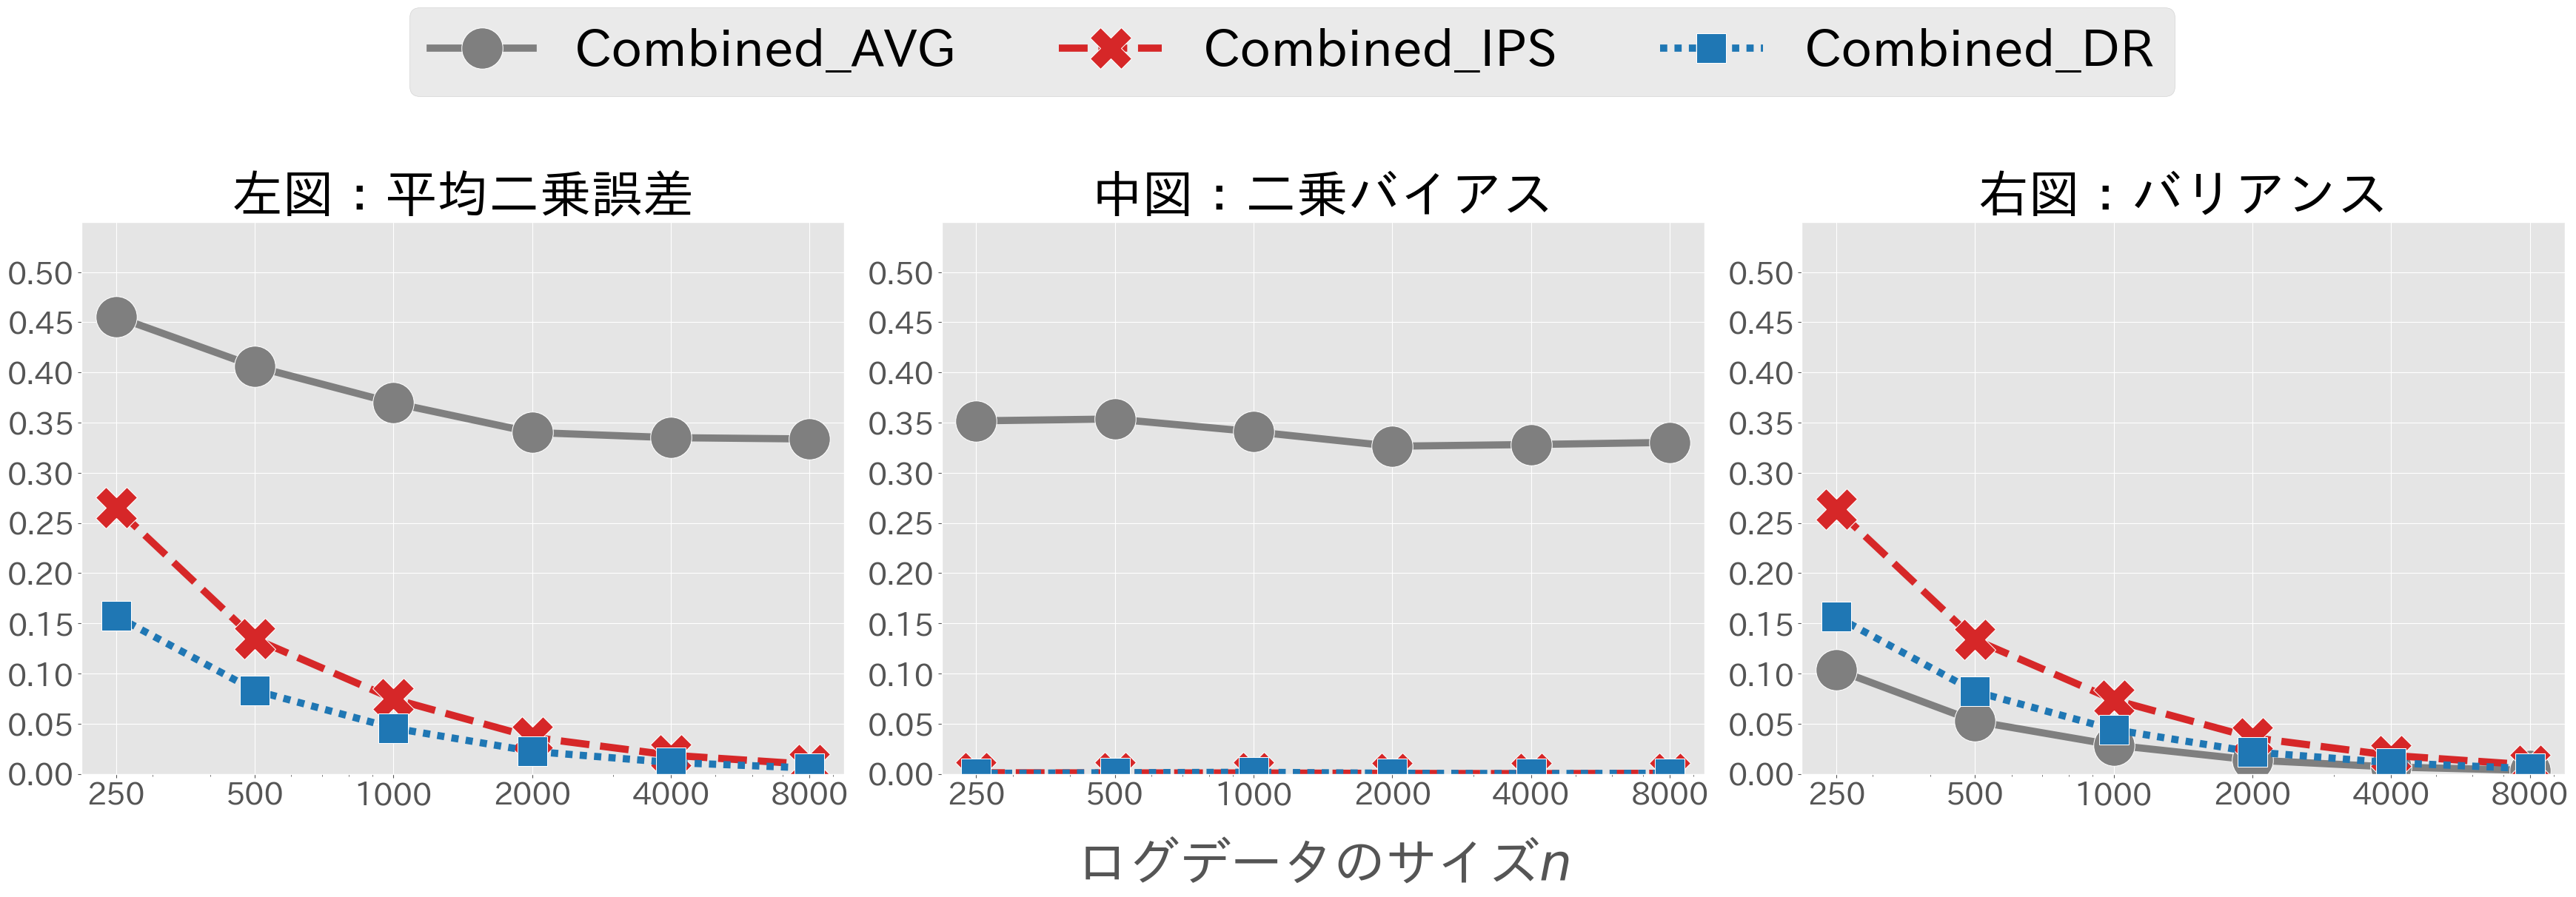

In [11]:
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        #palette=["tab:grey", "tab:red"],
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_data,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.55)
    ax.set_yticks(np.arange(0.0,0.55,0.05))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Combined_AVG", "Combined_IPS", "Combined_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")

### ログデータの行動数 **#A** を変化させる

##### Test始まり

In [41]:
def calc_cavg_scaled(dataset: dict) -> float:
    num_actions = dataset["a_mat"].shape[1]  # 行動数を取得
    return (dataset["r_mat"].sum(1) / num_actions).mean()

def calc_cips_scaled(
    dataset: dict,
    pi: np.ndarray
) -> float:
    num_actions = dataset["a_mat"].shape[1]  # 行動数を取得
    pi_0 = dataset["pi_0"]
    a_1 = dataset["a_mat"]
    a_0 = 1 - dataset["a_mat"]
    # 分母を定義
    dinominator = (pi_0 * a_1).sum(axis=1, keepdims=True)
    # 重みを計算
    w_1 = (pi * a_1) / dinominator
    w_0 = (1 * a_0 - pi * a_0) / (1 - dinominator)
    w_1, w_0 = np.nan_to_num(w_1, 0), np.nan_to_num(w_0, 0)
    
    return (dataset["r_mat"] * w_1 + dataset["r_mat"] * w_0).sum(1).mean() / num_actions

# Combined-DR推定量
def calc_cdr_scaled(
    dataset: dict,
    pi: np.ndarray,
    q1_hat: np.ndarray,
    q0_hat: np.ndarray
) -> float:
    num_actions = dataset["a_mat"].shape[1]  # 行動数を取得
    pi_0 = dataset["pi_0"]
    a_1 = dataset["a_mat"]
    a_0 = 1 - dataset["a_mat"]
    # 分母を定義
    dinominator = (pi_0 * a_1).sum(axis=1, keepdims=True)
    # 重みを計算
    w_1 = (pi * a_1) / (dinominator)
    w_0 = (1 * a_0 - pi * a_0) / (1 - dinominator)
    w_1, w_0 = np.nan_to_num(w_1, 0), np.nan_to_num(w_0, 0)
    # Combined-DR推定量
    cdr = w_1 * (dataset["r_mat"] - q1_hat*a_1) + w_0 * (dataset["r_mat"] - q0_hat*a_0)
    cdr += (pi * q1_hat) + ((1 - pi) * q0_hat)
    return cdr.sum(1).mean() / num_actions

def calc_true_value_scaled(
    num_data:int,
    dim_context: int,
    num_actions: int,
    theta_1: np.ndarray,
    theta_0:np.ndarray,
    M_1: np.ndarray,
    M_0: np.ndarray,
    b_1: np.ndarray,
    b_0: np.ndarray,
    beta: float = 1.0,
    k: int = 1
) -> float:
    """評価方策の真の性能を近似する."""
    bandit_data = generate_synthetic_data(
        num_data=num_data,
        dim_context=dim_context,
        num_actions=num_actions,
        beta=beta,
        theta_1=theta_1,
        M_1=M_1,
        b_1=b_1,
        theta_0=theta_0,
        M_0=M_0,
        b_0=b_0,
        k=k
    )
    
    cate_x_a = bandit_data["cate_x_a"]
    pi =eps_greedy_policy(cate_x_a)
    
    q_x_a_1 =bandit_data["q_x_a_1"]
    q_x_a_0 = bandit_data["q_x_a_0"]

    return (pi*q_x_a_1+(1-pi)*q_x_a_0).sum(1).mean() / num_actions

In [42]:
## シミュレーション設定
num_runs = 10# シミュレーションの繰り返し回数(5000)
dim_x = 5 # 特徴量xの次元
num_data = 500 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [25, 50, 100, 200, 400, 800] # 行動数, |A|
num_actions_list = [25, 50, 100] # 行動数, |A|
k = 10

In [43]:
result_df_list = []

for num_actions in num_actions_list:
    # 期待報酬関数を定義するためのパラメータを抽出
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    
    ## 評価方策の真の性能 (policy value) を計算
    policy_value = calc_true_value_scaled(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,
        k=k
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        # データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state=_,
            k=k, random_policy=True
        )

        # ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        # ログデータを用いてオフ方策評価を実行
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_cavg_scaled(offline_logged_data)
        estimated_policy_values["new_ips"] = calc_cips_scaled(offline_logged_data, pi)
        estimated_policy_values["new_dr"] = calc_cdr_scaled(
            offline_logged_data, pi,
            q0_hat=offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat=offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )

        estimated_policy_value_list.append(estimated_policy_values)

    # シミュレーション結果を集計
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )

# 結果を統合
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

# 必要に応じて結果を表示または保存
print(result_df_actions)


num_actions=100...: 100%|██████████| 10/10 [00:00<00:00, 10.78it/s]

    index      est     value  num_actions            se          bias  \
0       0      avg  0.232641           25  1.384609e-03  8.195934e-04   
1       0  new_ips  0.253717           25  2.602912e-04  8.750118e-06   
2       0   new_dr  0.250865           25  3.604727e-04  1.904408e-07   
3       1      avg  0.253729           25  2.599042e-04  8.195934e-04   
4       1  new_ips  0.296139           25  6.910714e-04  8.750118e-06   
..    ...      ...       ...          ...           ...           ...   
85      8  new_ips  0.289980          100  1.202132e-07  3.440505e-06   
86      8   new_dr  0.288550          100  3.157196e-06  2.351399e-06   
87      9      avg  0.284365          100  3.554296e-05  1.117487e-05   
88      9  new_ips  0.289982          100  1.187956e-07  3.440505e-06   
89      9   new_dr  0.289201          100  1.266400e-06  2.351399e-06   

        variance  true_value  
0   7.364726e-05    0.269851  
1   3.644893e-04    0.269851  
2   3.772341e-04    0.269851  

In [44]:
result_df_actions[:40]

,index,est,value,num_actions,se,bias,variance,true_value
0,0,avg,0.232641,25,1.384609e-03,8.195934e-04,7.364726e-05,0.269851
1,0,new_ips,0.253717,25,2.602912e-04,8.750118e-06,3.644893e-04,0.269851
2,0,new_dr,0.250865,25,3.604727e-04,1.904408e-07,3.772341e-04,0.269851
3,1,avg,0.253729,25,2.599042e-04,8.195934e-04,1.564250e-04,0.269851
4,1,new_ips,0.296139,25,6.910714e-04,8.750118e-06,5.442972e-04,0.269851
5,1,new_dr,0.293113,25,5.411256e-04,1.904408e-07,5.210131e-04,0.269851
6,2,avg,0.245704,25,5.830913e-04,8.195934e-04,2.008169e-05,0.269851
7,2,new_ips,0.275278,25,2.945086e-05,8.750118e-06,6.094999e-06,0.269851
8,2,new_dr,0.274014,25,1.733279e-05,1.904408e-07,1.388957e-05,0.269851
9,3,avg,0.232225,25,1.415685e-03,8.195934e-04,8.094688e-05,0.269851


In [24]:
estimated_policy_value_list # 10回文

[{'avg': 28.649105630269908,
  'new_ips': 28.65213480035996,
  'new_dr': 28.863154289440782},
 {'avg': 29.21188573697048,
  'new_ips': 29.291985335054385,
  'new_dr': 29.18288776292106},
 {'avg': 28.820938062327375,
  'new_ips': 29.007560559253484,
  'new_dr': 29.107079357609422},
 {'avg': 28.595993436502855,
  'new_ips': 28.771504873450393,
  'new_dr': 28.844009338570554},
 {'avg': 28.84510082188075,
  'new_ips': 28.613862252504997,
  'new_dr': 28.697163574014922},
 {'avg': 29.12504015599931,
  'new_ips': 29.329250296498998,
  'new_dr': 29.400303315402994},
 {'avg': 28.139983081105882,
  'new_ips': 28.42121250702631,
  'new_dr': 28.441211615758366},
 {'avg': 28.553521170562348,
  'new_ips': 28.388059064812172,
  'new_dr': 28.482273890733083},
 {'avg': 28.605679251259648,
  'new_ips': 28.997989584076013,
  'new_dr': 28.854976351731963},
 {'avg': 28.436482178117235,
  'new_ips': 28.99819462148405,
  'new_dr': 28.920126935387437}]

In [25]:
policy_value #真の値

29.032661361303123

In [32]:
offline_logged_data["r_mat"]

array([[ 1.293935  ,  0.73013222, -1.1429318 , ...,  0.0317392 ,
         0.54210527,  0.69795417],
       [ 0.26415832, -0.03566048, -0.45912959, ...,  1.30417289,
         0.88543539, -0.0093793 ],
       [ 0.5105116 , -1.2718688 ,  2.03683784, ...,  1.35498429,
        -0.6274298 , -1.66830284],
       ...,
       [ 1.37693156,  0.05274308,  0.95929867, ...,  0.63774281,
        -1.93298001, -0.30185473],
       [ 1.28890399, -0.42863619, -1.53129377, ...,  0.49738825,
        -2.1559628 ,  0.7875932 ],
       [ 1.08221246,  2.44449012, -0.51747433, ...,  2.20927422,
        -0.0502463 ,  1.43022864]])

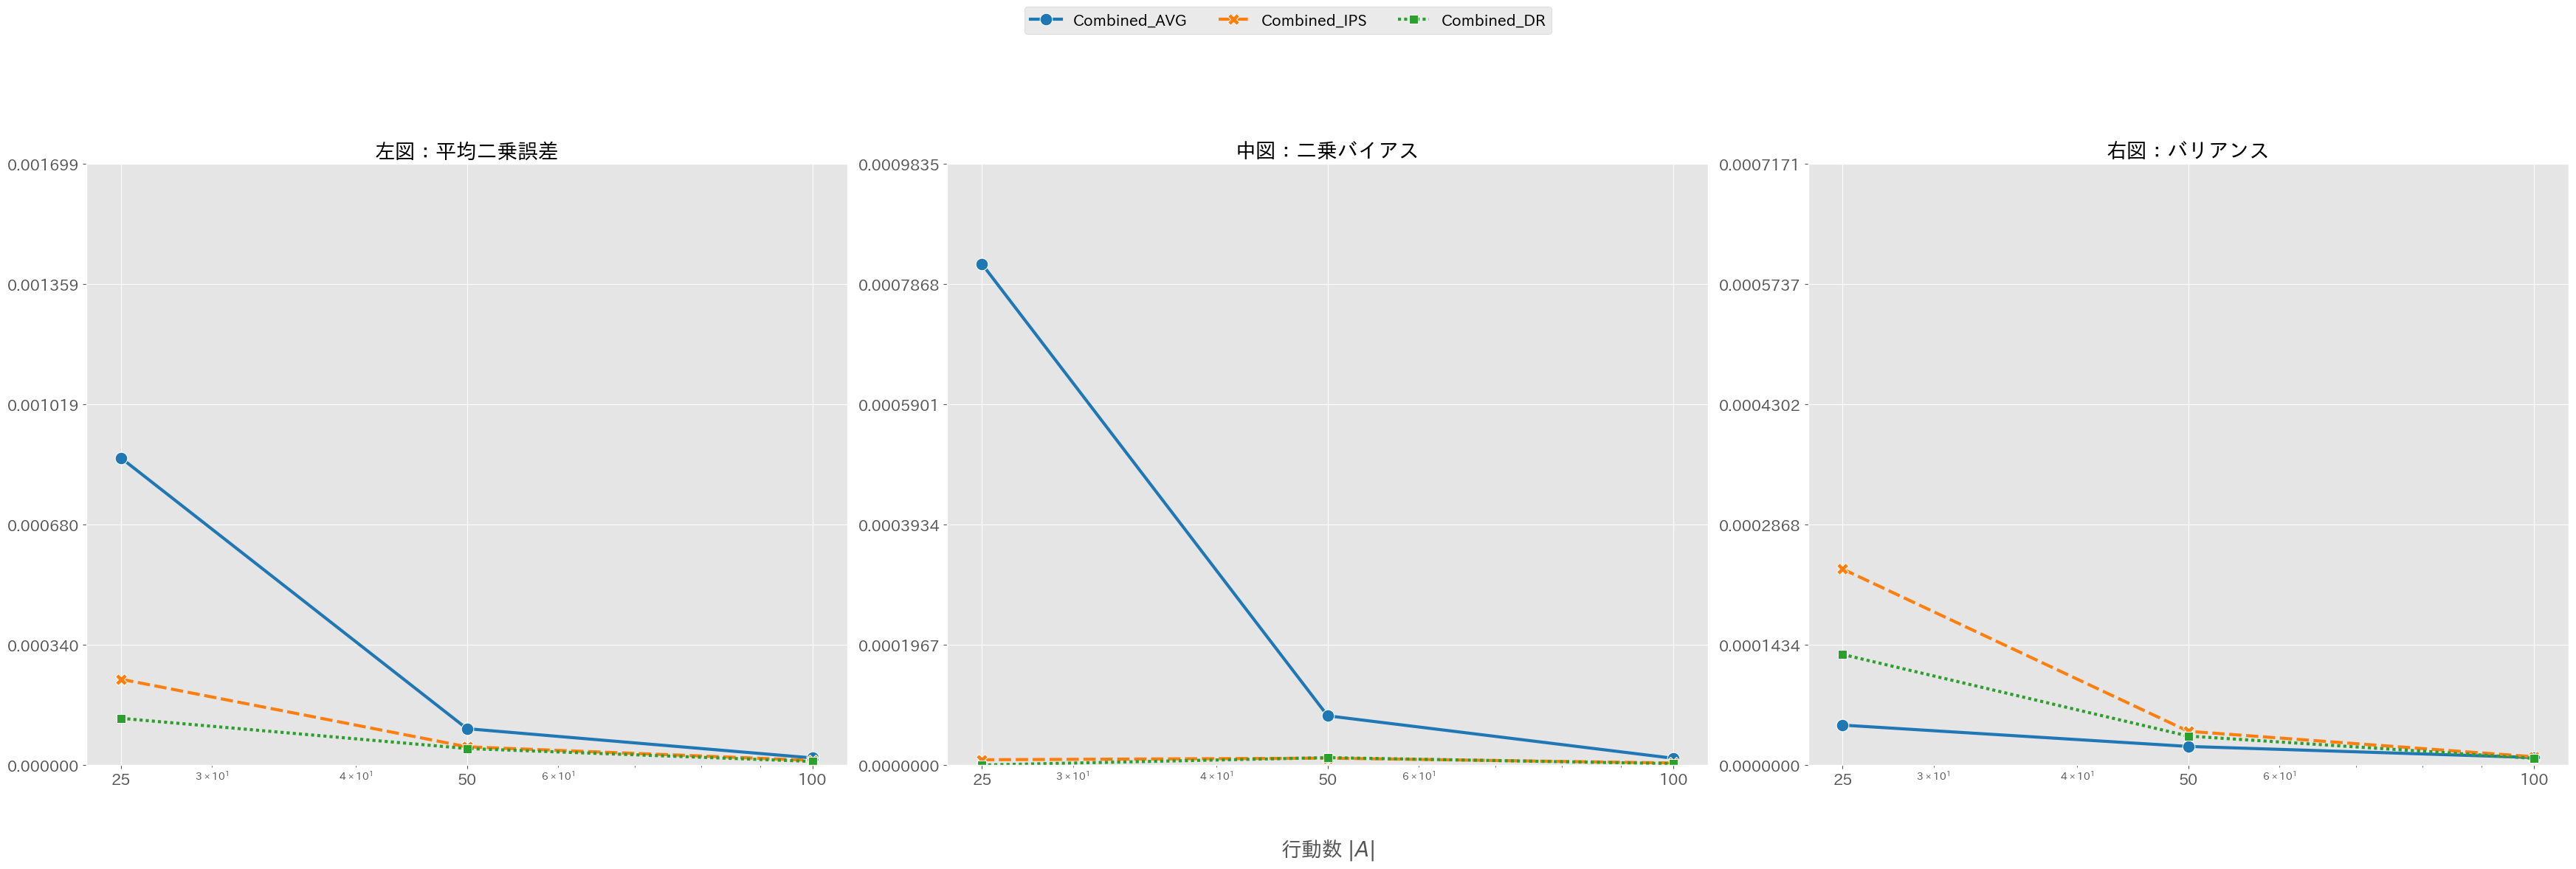

In [45]:
# 可視化のための設定
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

# グラフの作成
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=12,
        linewidth=3,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette="tab10",  # カラーパレットを指定
        data=result_df_actions,
    )
    ax.set_title(y_label_dict[y], fontsize=20)
    # y軸設定
    ax.set_ylabel("")
    ax.set_ylim(0.0, result_df_actions[y].max() * 1.2)
    ax.set_yticks(np.linspace(0, result_df_actions[y].max() * 1.2, 6))
    ax.tick_params(axis="y", labelsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # x軸設定
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動数 $|A|$", fontsize=20)
    else:
        ax.set_xlabel("")
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=15)
    ax.xaxis.set_label_coords(0.5, -0.12)

# 凡例を追加
fig.legend(
    ["Combined_AVG", "Combined_IPS", "Combined_DR"], 
    fontsize=15, 
    bbox_to_anchor=(0.5, 1.15), 
    ncol=4, 
    loc="center"
)

# グラフの描画
plt.show()

##### Test終わり

In [20]:
## シミュレーション設定
num_runs = 5000# シミュレーションの繰り返し回数(5000)
dim_x = 5 # 特徴量xの次元
num_data = 500 # ログデータのサイズ
beta = -0.2 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
num_actions_list = [20, 50, 100, 200, 400, 800] # 行動数, |A|
k = 10

In [33]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出


for num_actions in num_actions_list:
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,
        k=k
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions={num_actions}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
            k=k, random_policy=True
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)
        
        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions", num_actions,
        )
    )
result_df_actions = pd.concat(result_df_list).reset_index(level=0)

num_actions=100...: 100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


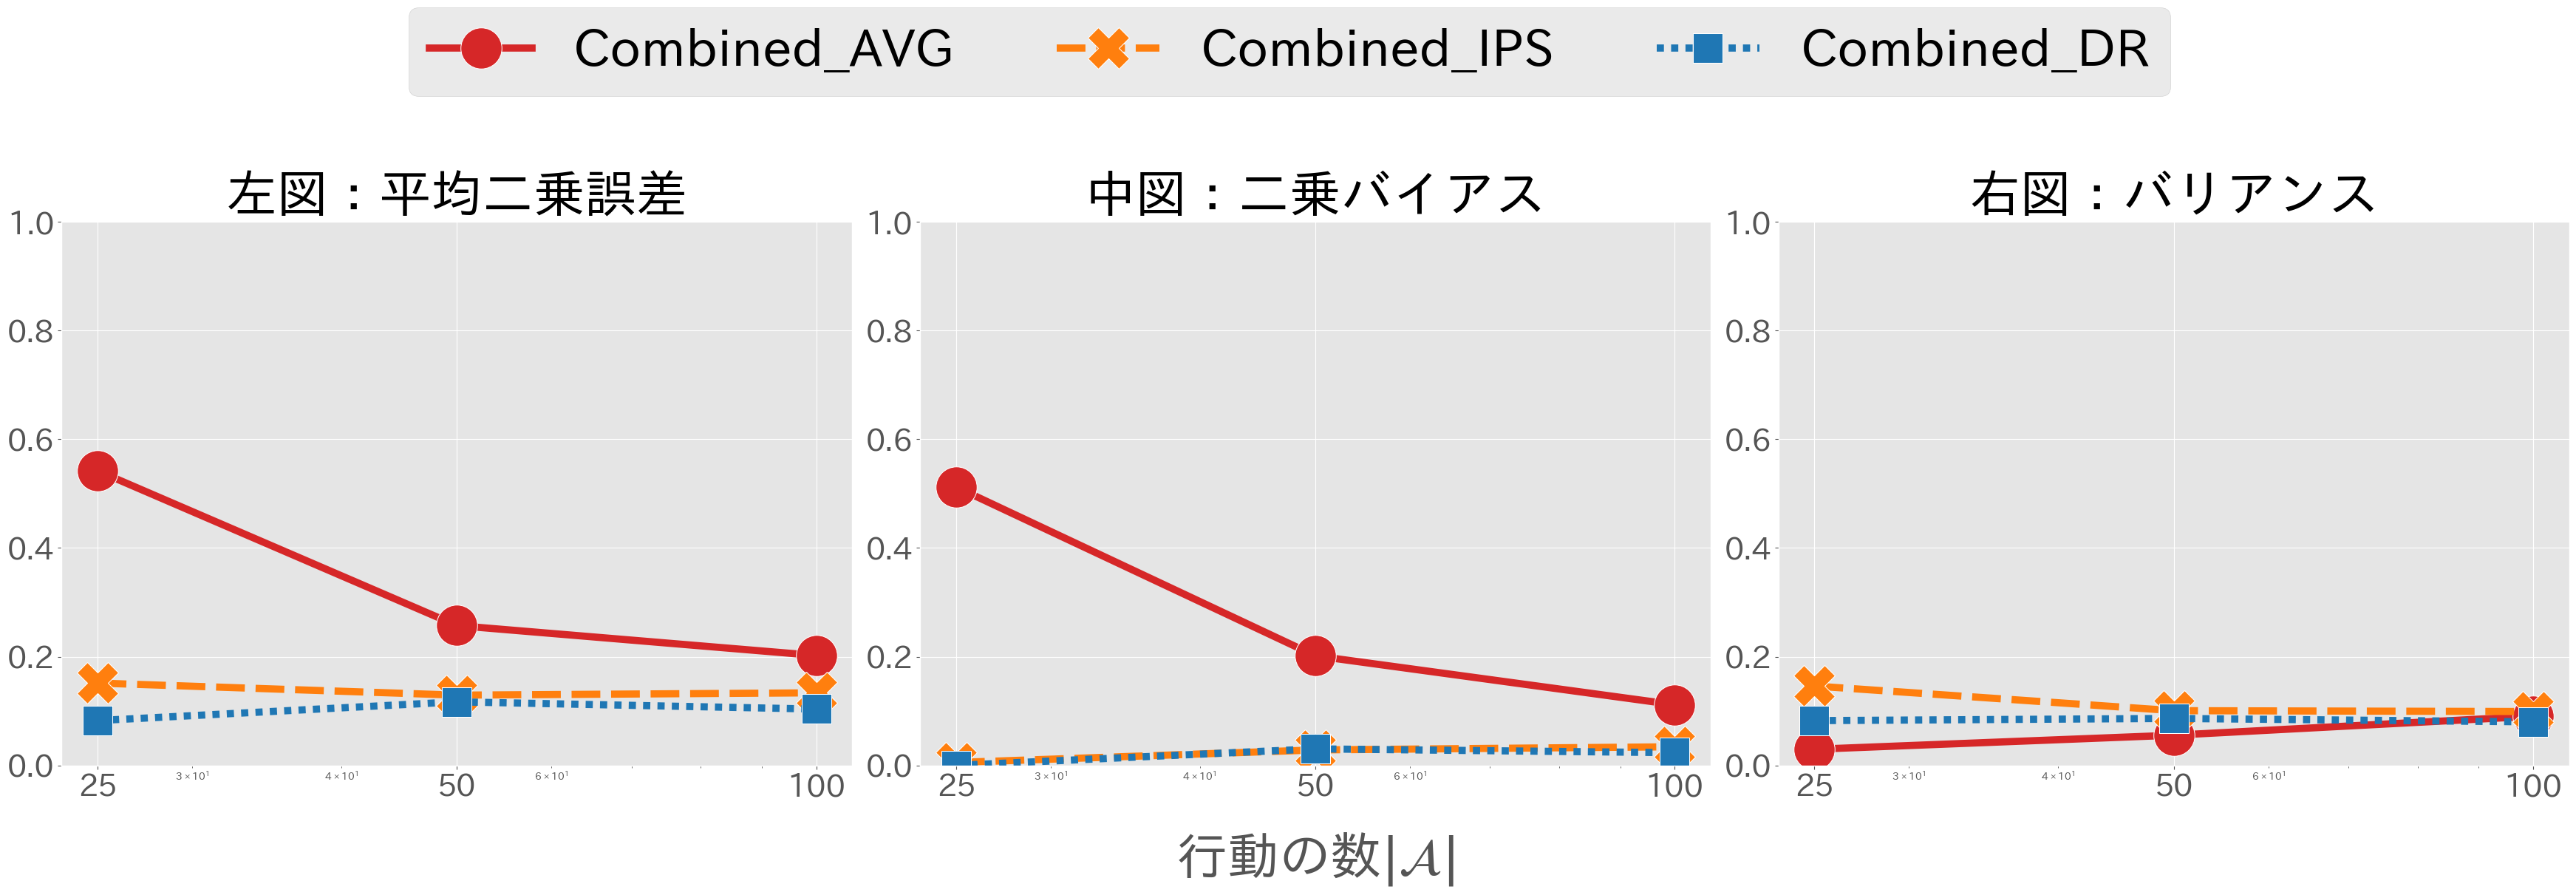

In [21]:
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange","tab:blue"],
        data=result_df_actions.query("est=='avg' or est == 'new_ips' or est == 'new_dr' ")
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"行動の数$|\mathcal{A}|$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_actions_list)
    ax.set_xticklabels(num_actions_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Combined_AVG", "Combined_IPS", "Combined_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")

### 行動の組み合わせの要素の数 **k** を変化させる

In [2]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_x = 10 # 特徴量xの次元
num_data = 1000 # ログデータのサイズ
num_actions = 20 # 行動数, |A|
beta = -3 # データ収集方策のパラメータ
random_state = 12345
random_ = check_random_state(random_state)
k_list = [3, 6, 9, 12, 15, 18]

In [3]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for k in k_list:  # 複数選択する行動数 k を変化
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,
        k = k
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_actions_per_user={k}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data,
            beta=beta,
            theta_1=theta_1,
            M_1=M_1,
            b_1=b_1,
            theta_0=theta_0,
            M_0=M_0,
            b_0=b_0,
            dim_context=dim_x,
            num_actions=num_actions,
            random_state=_,
            k=k,  # 行動要素数を指定
            random_policy=True,
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)

        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data,
            pi,
            q0_hat=offline_logged_data["q_x_a_0"]
            + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat=offline_logged_data["q_x_a_1"]
            + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
        )

        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_actions_per_user", k
        )
    )

result_df_k = pd.concat(result_df_list).reset_index(level=0)


num_actions_per_user=18...: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


In [ ]:
# データを保存
# result_df_k.to_csv('data/random_model/result_based_k.csv', index=False)

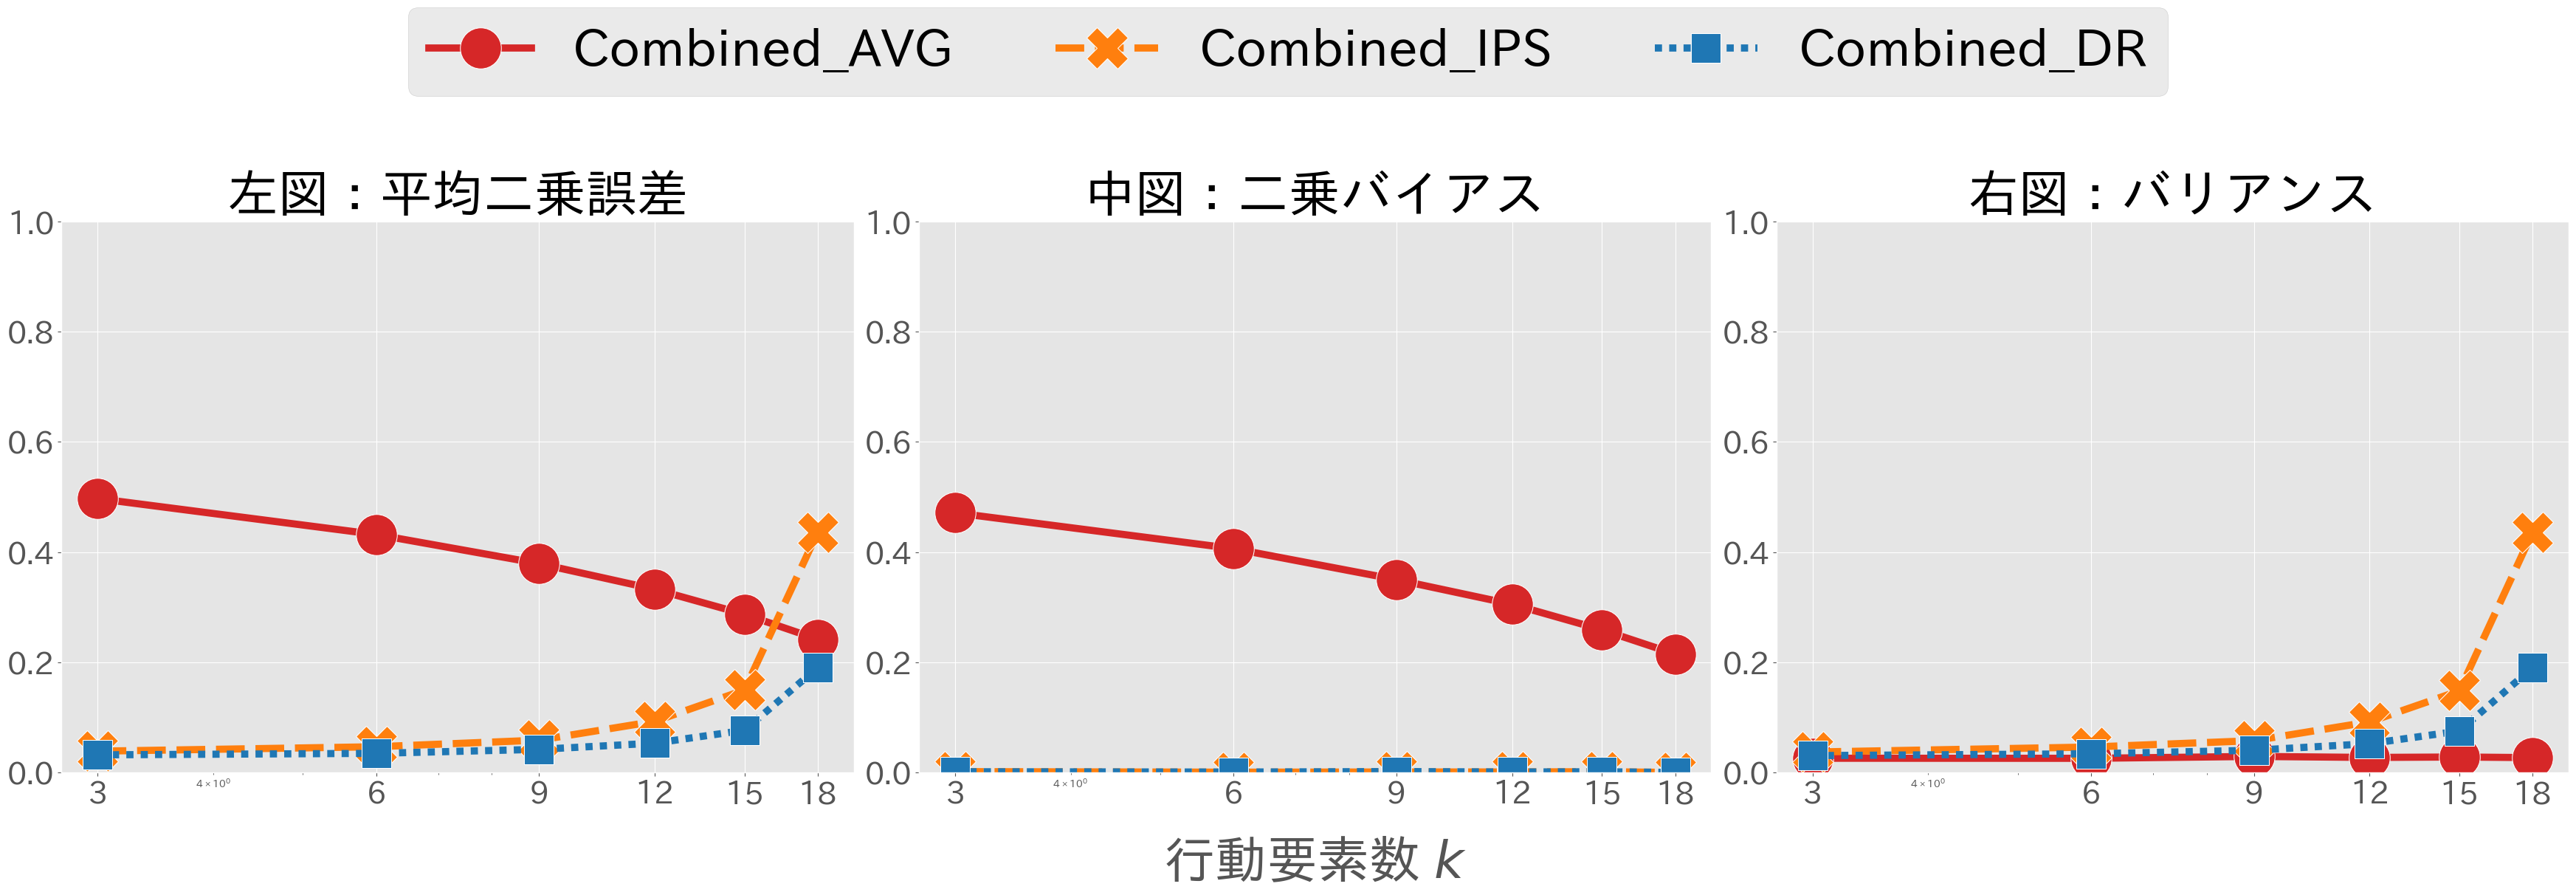

In [11]:
y_label_dict_k = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_actions_per_user",  # x軸は k
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:red", "tab:orange", "tab:blue"],
        data=result_df_k.query("est=='cavg' or est == 'cips' or est == 'cdr'")
    )
    ax.set_title(y_label_dict_k[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")  # kが大きい場合の可視化のためログスケール
    if i == 1:
        ax.set_xlabel(r"行動要素数 $k$", fontsize=50)  # x軸ラベル
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(k_list)  # kのリストを指定
    ax.set_xticklabels(k_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Combined_AVG", "Combined_IPS", "Combined_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")
plt.show()

## BTS(Bernoulli Thompson Sampling Model)

In [13]:
## シミュレーション設定
num_runs = 5# シミュレーションの繰り返し回数(500)
dim_x = 10 # 特徴量xの次元
num_actions = 20 # 行動数, |A|
beta = -3 # データ収集方策のパラメータ
test_data_size = 100000 # 評価方策の真の性能を近似するためのテストデータのサイズ
random_state = 12345
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000] # データ収集方策が収集したログデータのサイズ
k = 10    # 行動の組み合わせの要素の数

In [14]:
result_df_list = []
## 期待報酬関数を定義するためのパラメータを抽出
theta_1 = random_.normal(size=(dim_x, num_actions))
M_1 = random_.normal(size=(dim_x, num_actions))
b_1 = random_.normal(size=(1, num_actions))
theta_0 = random_.normal(size=(dim_x, num_actions))
M_0 = random_.normal(size=(dim_x, num_actions))
b_0 = random_.normal(size=(1, num_actions))

for num_data in num_data_list:
    
    ## 評価方策の真の性能(policy value)を計算
    policy_value = calc_true_value(
        num_data=10000,
        dim_context=dim_x,
        num_actions=num_actions,
        theta_1=theta_1,
        theta_0=theta_0,
        M_1=M_1,
        M_0=M_0,
        b_1=b_1,
        b_0=b_0,
        k=k
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, beta=beta,
            theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
            dim_context=dim_x, num_actions=num_actions,
            random_state = _,
            k=k, random_policy=False
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["cate_x_a"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["cavg"] = calc_cavg(offline_logged_data)
        estimated_policy_values["cips"] = calc_cips(offline_logged_data, pi)
        
        estimated_policy_values["cdr"] = calc_cdr(
            offline_logged_data, pi,
            q0_hat = offline_logged_data["q_x_a_0"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions)),
            q1_hat = offline_logged_data["q_x_a_1"] + random_.normal(-0.05, scale=0.05, size=(num_data, num_actions))
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data_bts = pd.concat(result_df_list).reset_index(level=0)

num_data=8000...: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


In [ ]:
# csvファイルに保存
# result_df_data.to_csv('data/bts_model/result_based_n.csv', index=False)

In [18]:
result_df_data

,index,est,value,num_data,se,bias,variance,true_value
0,0,cavg,-1.303878e-01,250,2.805134e+01,3.140463e+01,9.463735e-02,5.165963
1,0,cips,-1.585504e+06,250,2.513840e+12,2.663207e+28,2.663207e+28,5.165963
2,0,cdr,1.329904e+06,250,1.768631e+12,2.012391e+24,2.012387e+24,5.165963
3,1,cavg,-4.294799e-01,250,3.130899e+01,3.140463e+01,7.292607e-05,5.165963
4,2,cavg,-9.282461e-01,250,3.713939e+01,3.140463e+01,2.403220e-01,5.165963
5,3,cavg,-1.019904e+00,250,3.826496e+01,3.140463e+01,3.385896e-01,5.165963
6,3,cips,-2.655939e+10,250,7.054010e+20,2.663207e+28,2.662340e+28,5.165963
7,3,cdr,2.420197e+09,250,5.857353e+18,2.012391e+24,2.005530e+24,5.165963
8,4,cavg,3.179199e-01,250,2.350353e+01,3.140463e+01,5.714445e-01,5.165963
9,4,cips,-4.895535e+14,250,2.396626e+29,2.663207e+28,1.065109e+29,5.165963


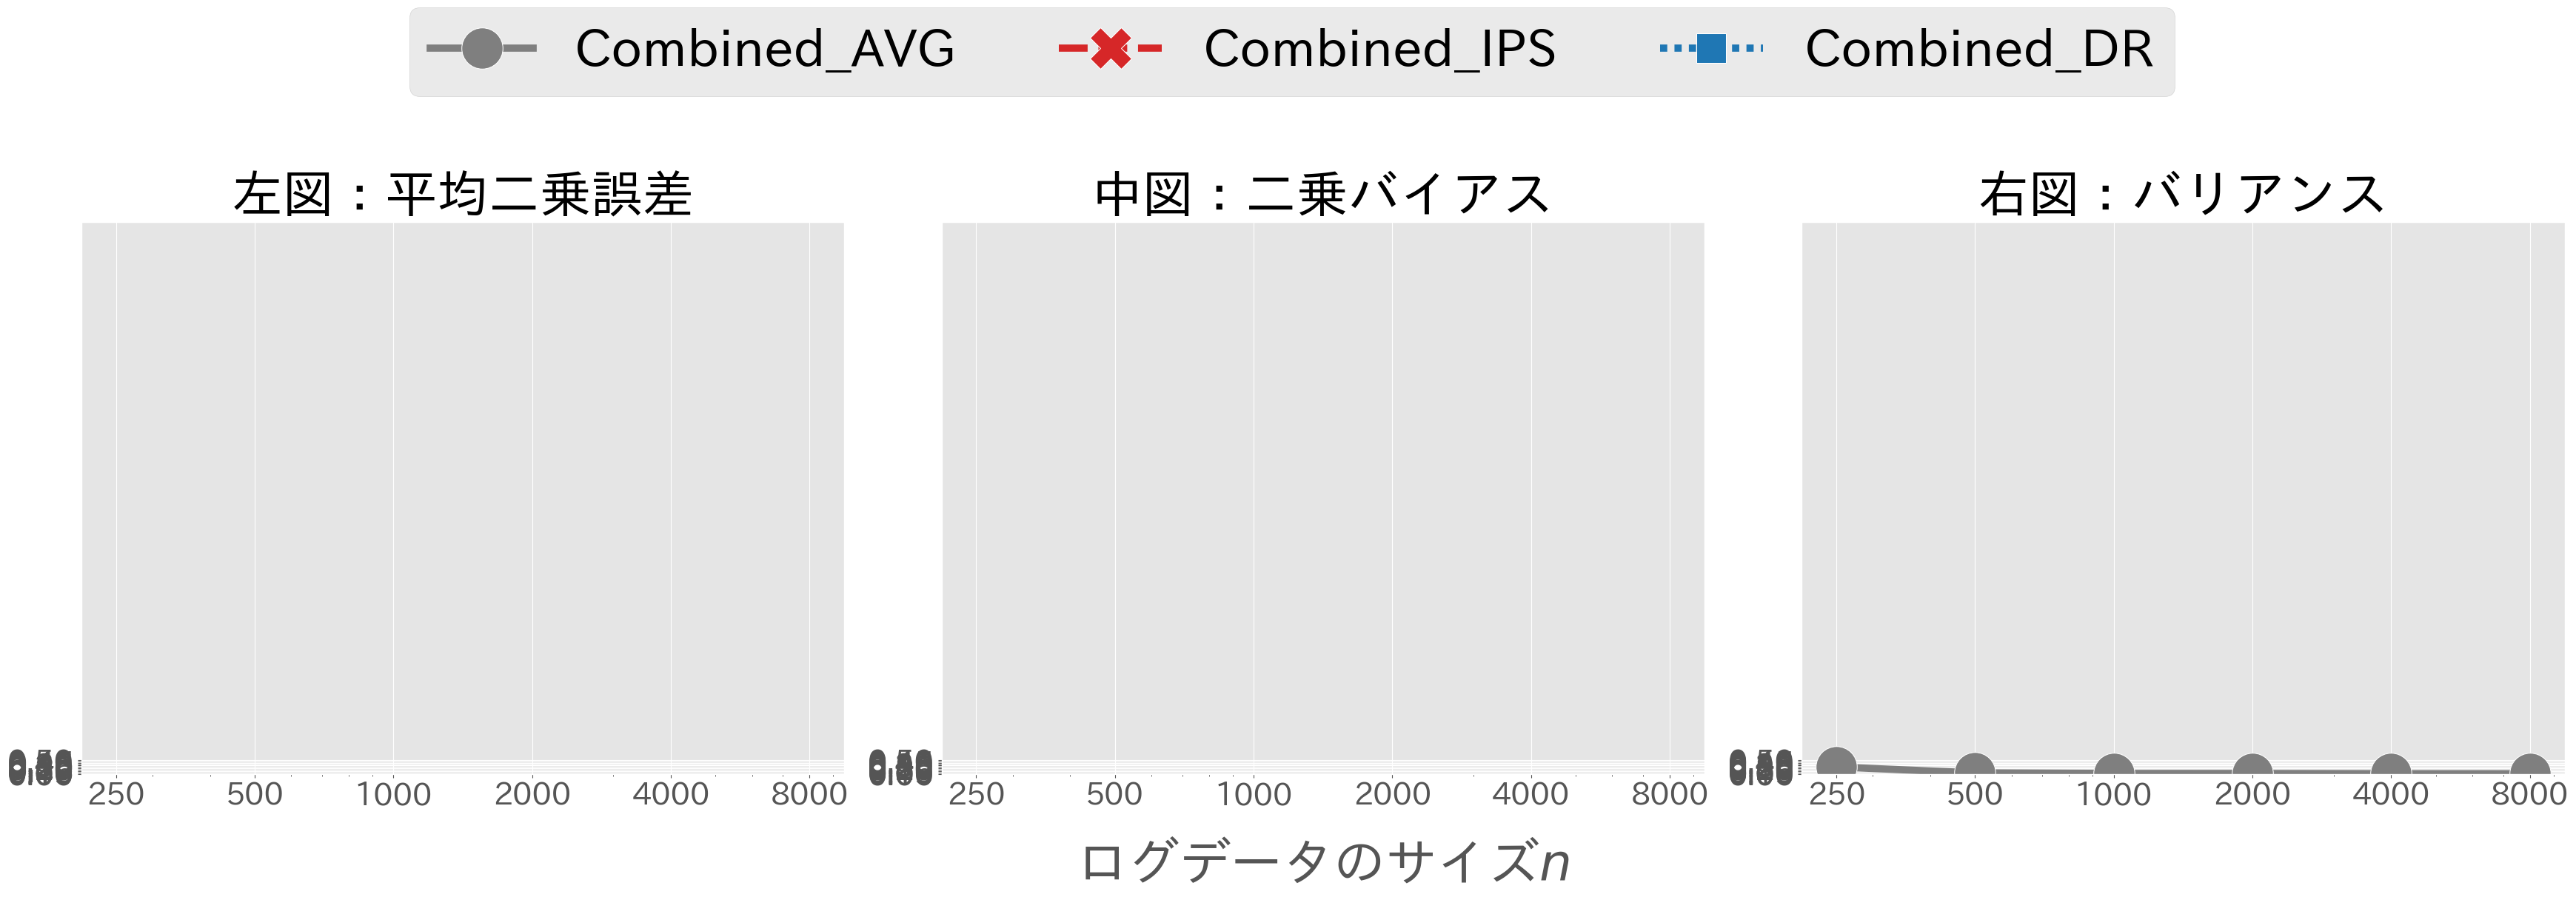

In [17]:
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        #palette=["tab:grey", "tab:red"],
        palette=["tab:grey", "tab:red", "tab:blue"],
        data=result_df_data,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 20)
    ax.set_yticks(np.arange(0.0,0.55,0.05))
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["Combined_AVG", "Combined_IPS", "Combined_DR"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center")